In [8]:
import Data_generator as dg
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.autograd import Variable
from torch import optim
import datetime
import math, random
import matplotlib.pyplot as plt
import Utility_Loss as UL
import Func_One_Asset as FOA
import NN_One_Asset as NOA
import Plot_One_Asset as POA
import matplotlib.ticker as mticker
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [9]:
# initialize seed, mu, sigma, S0, paths, steps, T and other data
seed_train = 66
seed_test = 37
npaths = 30000
seq_length = 240
T=10
s0=5
mu = 0.2
sigma = 0.5
#trading_cost= 0.01
gamma = 3.001
dt = T/seq_length
n_epochs = 100
learning_rate = 0.01
is_importance = False
trading_cost_vec = [0.0025,0.005,0.01,0.025,0.05]

In [10]:
ESR_simulated_vec = np.zeros(len(trading_cost_vec))
CI_upper_vec = np.zeros(len(trading_cost_vec))
CI_lower_vec = np.zeros(len(trading_cost_vec))
ESR_theo_vec = np.zeros(len(trading_cost_vec))
ESR_opt_vec = np.zeros(len(trading_cost_vec))

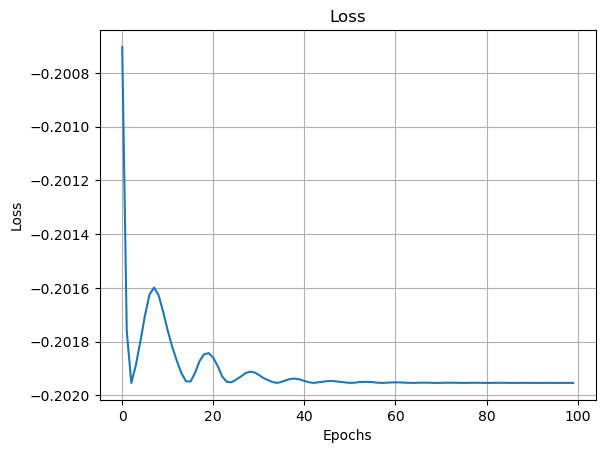

rnn.input_param.weight tensor([[0.]], device='cuda:0')
rnn.hidden_param.weight tensor([[1.]], device='cuda:0')
rnn.hidden_param.bias tensor([[0.0245]], device='cuda:0')
rnn.fc1_param.weight tensor([[-1.]], device='cuda:0')
rnn.fc1_param.bias tensor([[0.]], device='cuda:0')
rnn.fc2_param.weight tensor([[-1.]], device='cuda:0')
out.weight tensor([[1.]], device='cuda:0')


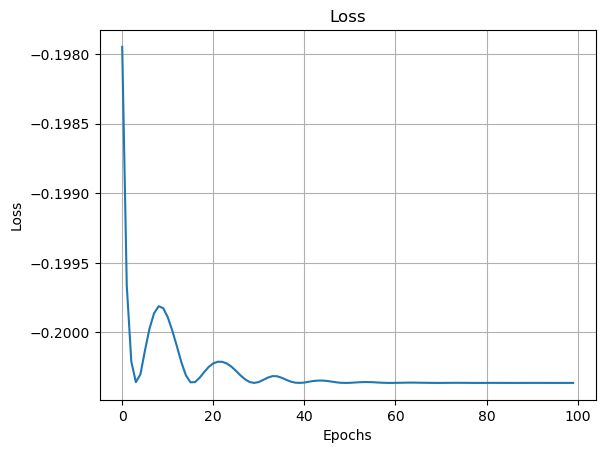

rnn.input_param.weight tensor([[0.]], device='cuda:0')
rnn.hidden_param.weight tensor([[1.]], device='cuda:0')
rnn.hidden_param.bias tensor([[0.0376]], device='cuda:0')
rnn.fc1_param.weight tensor([[-1.]], device='cuda:0')
rnn.fc1_param.bias tensor([[0.]], device='cuda:0')
rnn.fc2_param.weight tensor([[-1.]], device='cuda:0')
out.weight tensor([[1.]], device='cuda:0')


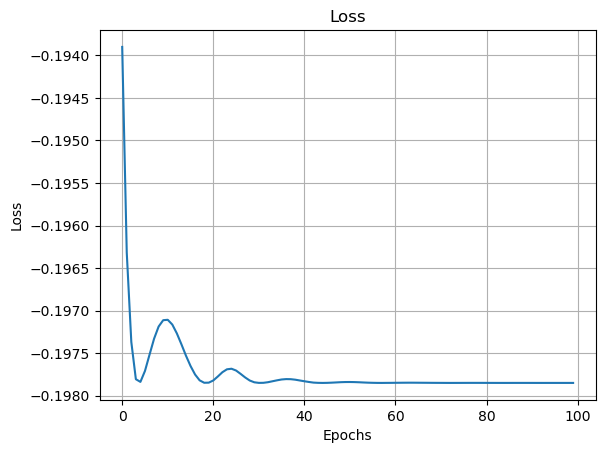

rnn.input_param.weight tensor([[0.]], device='cuda:0')
rnn.hidden_param.weight tensor([[1.]], device='cuda:0')
rnn.hidden_param.bias tensor([[0.0475]], device='cuda:0')
rnn.fc1_param.weight tensor([[-1.]], device='cuda:0')
rnn.fc1_param.bias tensor([[0.]], device='cuda:0')
rnn.fc2_param.weight tensor([[-1.]], device='cuda:0')
out.weight tensor([[1.]], device='cuda:0')


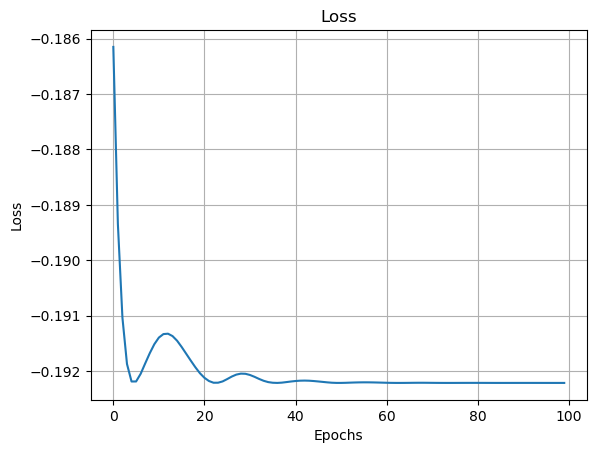

rnn.input_param.weight tensor([[0.]], device='cuda:0')
rnn.hidden_param.weight tensor([[1.]], device='cuda:0')
rnn.hidden_param.bias tensor([[0.0683]], device='cuda:0')
rnn.fc1_param.weight tensor([[-1.]], device='cuda:0')
rnn.fc1_param.bias tensor([[0.]], device='cuda:0')
rnn.fc2_param.weight tensor([[-1.]], device='cuda:0')
out.weight tensor([[1.]], device='cuda:0')


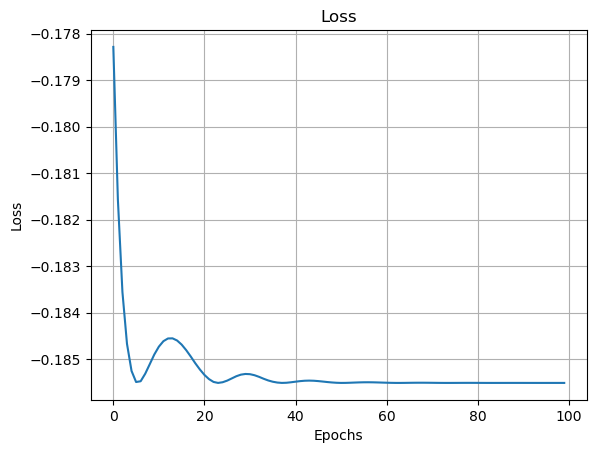

rnn.input_param.weight tensor([[0.]], device='cuda:0')
rnn.hidden_param.weight tensor([[1.]], device='cuda:0')
rnn.hidden_param.bias tensor([[0.0930]], device='cuda:0')
rnn.fc1_param.weight tensor([[-1.]], device='cuda:0')
rnn.fc1_param.bias tensor([[0.]], device='cuda:0')
rnn.fc2_param.weight tensor([[-1.]], device='cuda:0')
out.weight tensor([[1.]], device='cuda:0')


In [11]:
for i, trading_cost in enumerate(trading_cost_vec):
    
# Set portfolio
    returns, strategy, cost, Merton_opt, delta = FOA.make_portfolio(seed_train,mu,sigma,s0,npaths,seq_length,T,trading_cost,gamma)
# importance sampling
    returns, scaler = FOA.importance_sampling(is_importance,seed_train,mu,sigma,s0,npaths,seq_length,gamma,T)
# Set up model parameters, using paths as bath size, might not be the best, will try to fix later
    model, criterion, optimizer = FOA.make_model(1,1,1,npaths,seq_length, delta, gamma, learning_rate)
    model, losses = FOA.train_model(strategy.view(seq_length,1,1), Merton_opt, returns, cost, scaler, model, criterion, optimizer,n_epochs)
    returns, strategy, cost, Merton_opt, delta = FOA.make_portfolio(seed_test,mu,sigma,s0,npaths,seq_length,T,trading_cost,gamma)
    fina_strat, outputs = model(strategy.view(seq_length,1,1).double(), Merton_opt, returns, cost, None)
    ESR_simulated, CI, ESR_opt, ESR_theo = FOA.ESR(mu,sigma,gamma,outputs.detach().cpu().numpy(), T,trading_cost)
    ESR_simulated_vec[i] = ESR_simulated
    CI_upper_vec[i] = CI[0]
    CI_lower_vec[i] = CI[1]
    ESR_theo_vec[i] = ESR_theo
    ESR_opt_vec[i] = ESR_opt
    # After training is complete, clear memory by doing the following:

    # Delete model and optimizer
    del model
    del optimizer

    # Empty the CUDA cache
    torch.cuda.empty_cache()
    

e:\Documents\OneDrive - Dublin City University\backtest_data\Backtest\Plot_One_Asset.py:37: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  Cmean, = ax.plot(x, simulated, 'k--',color='blue')


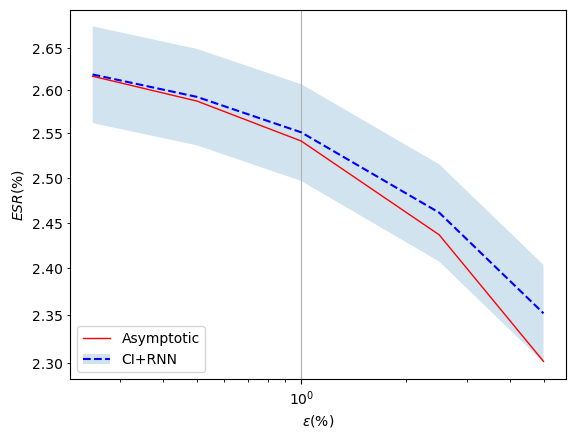

In [12]:
POA.plot_esr(np.array(trading_cost_vec),ESR_theo_vec,CI_lower_vec,CI_upper_vec,ESR_simulated_vec)

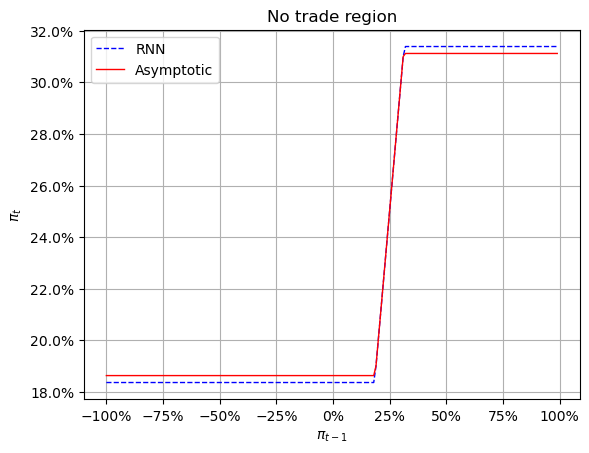

In [26]:
# Data for plotting
lowerbound = -1
upperbound = 1
optimal_input = Merton_opt
t = torch.tensor(np.arange(lowerbound, upperbound, 0.01)).to(device)
s = model.rnn.fc2_param.weight*F.relu(model.rnn.fc1_param.weight*F.relu(optimal_input*model.rnn.input_param.weight+model.rnn.hidden_param.weight*t-Merton_opt+model.rnn.hidden_param.bias)+2*model.rnn.hidden_param.bias)+Merton_opt+model.rnn.hidden_param.bias
delta_real = np.power(3/(2*gamma)*np.power(Merton_opt,2)*np.power(1-Merton_opt,2)*trading_cost,1/3)+((5-2*gamma)/(10*gamma)*Merton_opt*(Merton_opt)-3/(20*gamma))*2*trading_cost
s2 = model.rnn.fc2_param.weight*F.relu(model.rnn.fc1_param.weight*F.relu(optimal_input*model.rnn.input_param.weight+model.rnn.hidden_param.weight*t-(Merton_opt-delta_real))+2*delta_real)+Merton_opt+delta_real
s3 = model.rnn.fc2_param.weight*F.relu(model.rnn.fc1_param.weight*F.relu(optimal_input*model.rnn.input_param.weight+model.rnn.hidden_param.weight*t-(Merton_opt-delta))+2*delta)+Merton_opt+delta


fig, ax = plt.subplots()
ax.plot(t.cpu().detach(), s.cpu().view(-1).detach(), label='RNN', color = 'blue', linestyle= '--', linewidth = 1)
ax.plot(t.cpu().detach(), s2.cpu().view(-1).detach(), label='Asymptotic', color = 'red', linewidth = 1)

ax.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1.0))
ax.xaxis.set_major_formatter(mticker.PercentFormatter(xmax=1.0))
ax.legend()


ax.set(xlabel=r'$\pi_{t-1}$', ylabel=r'$\pi_t$',
       title='No trade region')
ax.grid()


# save the plot
current_time = datetime.datetime.now()
formatted_time = current_time.strftime("%d-%m-%Y_%H-%M-%S")
file_name = f"result__one_{formatted_time}.png"
fig.savefig(file_name,dpi=500,pad_inches = 0.1,bbox_inches = 'tight')
plt.show()